In [1]:
import os
os.chdir('../')

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as tF
import numpy as np
import matplotlib.pyplot as plt

import functional as F

In [37]:
def label_to_membership(labels):
    n_class = labels.max() + 1
    n_samples = labels.shape[0]
    membership = torch.zeros(n_samples, n_class)
    for j in range(n_class):
        idx_j = labels == j
        membership[idx_j, j] = 1.
    return membership

In [38]:
n_class = 5
n_features = 32
n_samples = 100
eps = 0.5
mu = 0.1
features = torch.randn(n_samples, n_features).float() # shape: (n_samples, n_features)
features = tF.normalize(features)
labels = torch.randint(0, n_class, size=(n_samples, ))
membership = label_to_membership(labels)

In [39]:
def optimal_Us(Z, Pi):
    Us = []
    for j in range(Pi.shape[1]):
        U, S, V = torch.linalg.svd(Z @ Pi[:, j].diag() @ Z.T)
        Us.append(U @ (S**0.5).diag())
    return torch.stack(Us)

true_Us = optimal_Us(features.T, membership)

## True MCR2 loss

In [40]:
def true_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def true_loss_compress(Z, Pi, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    compress_loss = 0.
    for j in range(Pi.shape[1]):
        trPi = Pi[:, j].sum()
        scalar = d / (trPi * eps)
        log_det = torch.logdet(I + scalar * Z @ Pi[:, j].diag() @ Z.T)
        compress_loss += trPi / (2 * n) * log_det
    return compress_loss

In [41]:
true_R = true_loss_discrimn(features.T, eps)
true_Rc = true_loss_compress(features.T, membership, eps)
true_dR = true_R - true_Rc
true_dR, true_R, true_Rc

(tensor(3.8725), tensor(16.4725), tensor(12.6000))

## First Variational Form

In [19]:
def var_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def var_loss_compress(Z, Pi, Us, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    compress_loss = 0.
    for j in range(Pi.shape[1]):
        trPi_j = Pi[:, j].sum()
        scalar_j = trPi_j / (2 * n)
        norms = torch.linalg.norm(Us[j], axis=0, keepdims=True, ord=2) ** 2
        compress_loss += scalar_j * torch.log(1 + d / (trPi_j * eps) * norms).sum()
    return compress_loss

def var_reg_U(Z, Pi, Us):
    loss_reg = 0.
    for j in range(Pi.shape[1]):
        loss_reg += torch.linalg.norm((Z @ Pi[:, j].diag() @ Z.T) - (Us[j] @ Us[j].T), ord='fro')
    return loss_reg

In [20]:
Us = torch.randn(n_class, n_features, n_features)
true_Us = optimal_Us(features.T, membership)
Us = true_Us
var_R = var_loss_discrimn(features.T, eps)
var_Rc = var_loss_compress(features.T, membership, Us, eps)
var_Rreg_U = var_reg_U(features.T, membership, Us)
var_dR = var_R - var_Rc - mu * var_Rreg_U
var_dR, var_R, var_Rc, var_Rreg_U

(tensor(3.8864), tensor(16.4909), tensor(12.6046), tensor(1.9075e-05))

In [91]:
class MCR2Variational(nn.Module):
    """Equation 9 in writeup. """
    def __init__(self, eps, mu):
        super(MCR2Variational, self).__init__()
        self.eps = eps
        self.mu = mu
        
    def loss_discrimn(self, Z):
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        return 0.5 * torch.logdet(I + d / (n * self.eps) * Z @ Z.T)

    def loss_compress(self, Z, Pi, Us):
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        compress_loss = 0.
        for j in range(Pi.shape[1]):
            trPi_j = Pi[:, j].sum()
            scalar_j = trPi_j / (2 * n)
            norms = torch.linalg.norm(Us[j], axis=0, keepdims=True, ord=2) ** 2
            compress_loss += scalar_j * torch.log(1 + d / (trPi_j * self.eps) * norms).sum()
        return compress_loss

    def reg_U(self, Z, Pi, Us):
        loss_reg = 0.
        for j in range(Pi.shape[1]):
            loss_reg += torch.linalg.norm((Z @ Pi[:, j].diag() @ Z.T) - (Us[j] @ Us[j].T), ord='fro') ** 2
        return 0.5 * loss_reg
    
    def forward(self, Z, Pi, Us):
        loss_R = self.loss_discrimn(Z.T)
        loss_Rc = self.loss_compress(Z.T, Pi, Us)
        loss_reg_U = self.mu * self.reg_U(Z.T, Pi, Us)
        loss_obj = loss_R - loss_Rc - loss_reg_U
        return -loss_obj, loss_R, loss_Rc, loss_reg_U

In [11]:
criterion_mcr2var = MCR2Variational(eps, mu)
criterion_mcr2var(features, membership, true_Us)

(tensor(3.8747), tensor(16.4784), tensor(12.6037), tensor(9.6607e-07))

## Second Variational Form

In [12]:
def var_loss_discrimn(Z, eps):
    return true_loss_discrimn(Z, eps)

def var_loss_compress(Z, Pi, Us, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    compress_loss = 0.
    for j in range(Pi.shape[1]):
        trPi_j = Pi[:, j].sum()
        scalar_j = trPi_j / (2 * n)
        norms = torch.linalg.norm(Us[j], axis=0, keepdims=True, ord=2) ** 2
        compress_loss += scalar_j * torch.log(1 + d / (trPi_j * eps) * norms).sum()
    return compress_loss

def var_reg_U(Z, Pi, Us):
    loss_reg = 0.
    for j in range(Pi.shape[1]):
        loss_reg += torch.linalg.norm((Z @ Pi[:, j].diag() @ Z.T) - (Us[j] @ Us[j].T), ord='fro')
    return loss_reg

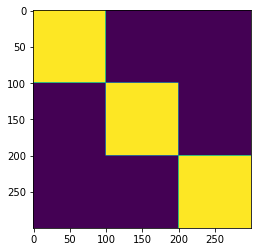

In [25]:
Z = torch.zeros(300, 300)
Z[:100, :100] = 1.
Z[100:200, 100:200] = 1.
Z[200:, 200:] = 1

In [42]:
Z_train = torch.zeros(400, 400).float()
Z_train[:200, :200] = 1.
Z_train[200:, 200:] = 1.

In [50]:
Z_train = torch.zeros(20, 10).float()
Z_train[:10, :5] = 1.
Z_train[10:, 5:] = 1.
Z_train = F.normalize(Z_train)
Z_train

tensor([[0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0

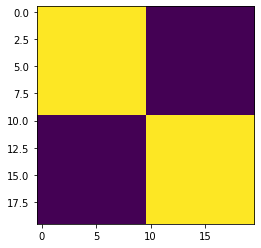

In [51]:
plt.imshow(Z_train @ Z_train.T)

In [176]:
Pi = torch.zeros(20, 2)
Pi[:10, 0] = 1.
Pi[10:, 1] = 1.
eps = 0.5
mu = 5.

criterion_mcr2var = MCR2Variational(eps, mu)
true_Us = optimal_Us(Z_train.T, Pi)
Us = nn.Parameter(
#     true_Us,
    torch.randn(2, 10, 10) / 100,
    requires_grad=True
    )
import torch.optim as optim
optimizer_Us = optim.SGD([Us], lr=0.005)

In [179]:
for epoch in range(4000):
    optimizer_Us.zero_grad()
    loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_train, Pi, Us)
    print(epoch, -loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
    loss_obj.backward()
    optimizer_Us.step()

0 0.44812411069869995 2.397895336151123 1.9494688510894775 0.00030238376348279417
1 0.44895613193511963 2.397895336151123 1.9486371278762817 0.00030208862153813243
2 0.44978928565979004 2.397895336151123 1.9478042125701904 0.00030183763010427356
3 0.4506235718727112 2.397895336151123 1.9469702243804932 0.00030154886189848185
4 0.45145928859710693 2.397895336151123 1.9461348056793213 0.0003012346860487014
5 0.4522961974143982 2.397895336151123 1.945298194885254 0.00030094062094576657
6 0.45313429832458496 2.397895336151123 1.944460391998291 0.0003006348561029881
7 0.4539737105369568 2.397895336151123 1.943621277809143 0.0003003363381139934
8 0.4548143148422241 2.397895336151123 1.9427809715270996 0.00030006427550688386
9 0.4556562304496765 2.397895336151123 1.941939353942871 0.0002997627016156912
10 0.4564993381500244 2.397895336151123 1.941096544265747 0.0002994602546095848
11 0.457343727350235 2.397895336151123 1.940252423286438 0.0002991863584611565
12 0.45818936824798584 2.397895336

180 0.613724410533905 2.397895336151123 1.7839329242706299 0.00023801857605576515
181 0.6146909594535828 2.397895336151123 1.7829667329788208 0.0002376215998083353
182 0.6156573295593262 2.397895336151123 1.7820007801055908 0.0002372079761698842
183 0.6166236400604248 2.397895336151123 1.7810349464416504 0.00023677086574025452
184 0.6175895929336548 2.397895336151123 1.780069351196289 0.0002363662060815841
185 0.6185553669929504 2.397895336151123 1.7791039943695068 0.00023594779486302286
186 0.619520902633667 2.397895336151123 1.7781388759613037 0.00023554384824819863
187 0.6204861998558044 2.397895336151123 1.7771739959716797 0.00023511162726208568
188 0.6214510202407837 2.397895336151123 1.7762095928192139 0.00023470385349355638
189 0.6224158406257629 2.397895336151123 1.775245189666748 0.00023428270651493222
190 0.6233802437782288 2.397895336151123 1.7742812633514404 0.00023385608801618218
191 0.6243443489074707 2.397895336151123 1.773317575454712 0.00023342757776845247
192 0.625308

292 0.7171475291252136 2.397895336151123 1.680556297302246 0.00019151877495460212
293 0.7179919481277466 2.397895336151123 1.6797122955322266 0.0001911100116558373
294 0.7188341617584229 2.397895336151123 1.678870439529419 0.00019072717987000942
295 0.7196746468544006 2.397895336151123 1.6780303716659546 0.00019034105935133994
296 0.7205128073692322 2.397895336151123 1.6771925687789917 0.00018994967103935778
297 0.7213491201400757 2.397895336151123 1.6763566732406616 0.00018953788094222546
298 0.7221834063529968 2.397895336151123 1.675522804260254 0.00018914314568974078
299 0.7230153679847717 2.397895336151123 1.6746912002563477 0.00018876348622143269
300 0.723845362663269 2.397895336151123 1.6738616228103638 0.00018836685921996832
301 0.724673330783844 2.397895336151123 1.6730340719223022 0.00018795901269186288
302 0.7254989743232727 2.397895336151123 1.6722087860107422 0.0001875927409855649
303 0.726322591304779 2.397895336151123 1.6713855266571045 0.00018718885257840157
304 0.727144

401 0.7949691414833069 2.397895336151123 1.6027722358703613 0.00015394922229461372
402 0.7955352067947388 2.397895336151123 1.6022064685821533 0.0001536757335998118
403 0.7960981130599976 2.397895336151123 1.6016438007354736 0.00015339739911723882
404 0.796658456325531 2.397895336151123 1.601083755493164 0.00015310781600419432
405 0.7972159385681152 2.397895336151123 1.6005265712738037 0.00015283323591575027
406 0.7977705597877502 2.397895336151123 1.5999722480773926 0.00015254605386871845
407 0.7983224987983704 2.397895336151123 1.5994205474853516 0.00015229480050038546
408 0.7988715171813965 2.397895336151123 1.5988718271255493 0.00015201052883639932
409 0.7994176149368286 2.397895336151123 1.5983259677886963 0.00015174962754826993
410 0.7999610304832458 2.397895336151123 1.597782850265503 0.0001514740288257599
411 0.800501823425293 2.397895336151123 1.5972423553466797 0.00015118528972379863
412 0.801039457321167 2.397895336151123 1.5967049598693848 0.00015093316324055195
413 0.80157

563 0.8536204695701599 2.397895336151123 1.5441502332687378 0.00012462363520171493
564 0.853813111782074 2.397895336151123 1.5439577102661133 0.00012453575618565083
565 0.8540042042732239 2.397895336151123 1.543766736984253 0.0001244214945472777
566 0.8541940450668335 2.397895336151123 1.543576955795288 0.0001243399892700836
567 0.8543822765350342 2.397895336151123 1.543388843536377 0.00012423506996128708
568 0.8545687794685364 2.397895336151123 1.5432024002075195 0.0001241442223545164
569 0.8547539114952087 2.397895336151123 1.5430173873901367 0.00012404395965859294
570 0.8549375534057617 2.397895336151123 1.5428338050842285 0.0001239712437381968
571 0.8551197052001953 2.397895336151123 1.5426517724990845 0.00012386791058816016
572 0.8553004860877991 2.397895336151123 1.5424710512161255 0.0001237736432813108
573 0.8554797768592834 2.397895336151123 1.5422918796539307 0.00012369194882921875
574 0.8556574583053589 2.397895336151123 1.5421142578125 0.0001236136886291206
575 0.85583376884

739 0.871313750743866 2.397895336151123 1.526465892791748 0.0001157139049610123
740 0.8713552355766296 2.397895336151123 1.5264244079589844 0.00011569831258384511
741 0.8713961243629456 2.397895336151123 1.5263835191726685 0.00011566617467906326
742 0.8714366555213928 2.397895336151123 1.5263429880142212 0.00011567019100766629
743 0.8714771270751953 2.397895336151123 1.5263025760650635 0.00011563283624127507
744 0.8715169429779053 2.397895336151123 1.5262627601623535 0.00011560876737348735
745 0.8715563416481018 2.397895336151123 1.5262234210968018 0.0001155858626589179
746 0.871595561504364 2.397895336151123 1.5261842012405396 0.00011556578101590276
747 0.871634304523468 2.397895336151123 1.5261454582214355 0.00011556109529919922
748 0.8716727495193481 2.397895336151123 1.5261070728302002 0.00011552043724805117
749 0.8717108964920044 2.397895336151123 1.526068925857544 0.00011551349598448724
750 0.8717485666275024 2.397895336151123 1.526031255722046 0.00011549916962394491
751 0.871786

844 0.8741017580032349 2.397895336151123 1.523679256439209 0.00011432235623942688
845 0.8741172552108765 2.397895336151123 1.5236637592315674 0.00011430127779021859
846 0.8741328120231628 2.397895336151123 1.5236482620239258 0.00011428532161517069
847 0.874147891998291 2.397895336151123 1.5236331224441528 0.00011429496225900948
848 0.8741630911827087 2.397895336151123 1.5236179828643799 0.00011428473953856155
849 0.8741779923439026 2.397895336151123 1.523603081703186 0.00011427955178078264
850 0.8741928935050964 2.397895336151123 1.5235881805419922 0.00011426192213548347
851 0.8742074370384216 2.397895336151123 1.523573637008667 0.0001142704495578073
852 0.8742219805717468 2.397895336151123 1.5235590934753418 0.00011424541298765689
853 0.8742364048957825 2.397895336151123 1.5235446691513062 0.00011424365948187187
854 0.874250590801239 2.397895336151123 1.5235304832458496 0.00011425504635553807
855 0.8742648363113403 2.397895336151123 1.523516297340393 0.00011422427633078769
856 0.87427

997 0.8753636479377747 2.397895336151123 1.5224180221557617 0.00011368968989700079
998 0.8753672242164612 2.397895336151123 1.5224144458770752 0.0001136840000981465
999 0.8753708004951477 2.397895336151123 1.5224108695983887 0.00011366981198079884
1000 0.8753743767738342 2.397895336151123 1.5224072933197021 0.00011367149272700772
1001 0.8753779530525208 2.397895336151123 1.5224037170410156 0.0001136902574216947
1002 0.8753815293312073 2.397895336151123 1.522400140762329 0.00011366468243068084
1003 0.8753848671913147 2.397895336151123 1.5223968029022217 0.00011367377010174096
1004 0.8753883242607117 2.397895336151123 1.5223933458328247 0.00011367149272700772
1005 0.8753917813301086 2.397895336151123 1.5223898887634277 0.00011368229024810717
1006 0.8753952383995056 2.397895336151123 1.5223864316940308 0.00011364933016011491
1007 0.8753984570503235 2.397895336151123 1.522383213043213 0.0001136561477323994
1008 0.8754017949104309 2.397895336151123 1.5223798751831055 0.00011366012768121436


1151 0.875659167766571 2.397895336151123 1.5221226215362549 0.00011351807916071266
1152 0.8756601214408875 2.397895336151123 1.5221216678619385 0.00011352488945703954
1153 0.8756608963012695 2.397895336151123 1.5221209526062012 0.00011350841668900102
1154 0.8756615519523621 2.397895336151123 1.5221202373504639 0.00011353396985214204
1155 0.8756624460220337 2.397895336151123 1.522119402885437 0.00011351352441124618
1156 0.8756632208824158 2.397895336151123 1.5221185684204102 0.00011354760499671102
1157 0.8756641149520874 2.397895336151123 1.5221177339553833 0.00011350672139087692
1158 0.8756649494171143 2.397895336151123 1.5221168994903564 0.0001135129714384675
1159 0.8756656050682068 2.397895336151123 1.5221161842346191 0.00011352320143487304
1160 0.8756664395332336 2.397895336151123 1.5221153497695923 0.00011353568697813898
1161 0.8756672739982605 2.397895336151123 1.5221145153045654 0.0001135300044552423
1162 0.8756680488586426 2.397895336151123 1.5221138000488281 0.00011351693683536

1306 0.8757275342941284 2.397895336151123 1.5220543146133423 0.00011350728163961321
1307 0.8757277727127075 2.397895336151123 1.5220540761947632 0.0001135140992118977
1308 0.8757278919219971 2.397895336151123 1.5220539569854736 0.00011349366104695946
1309 0.8757278919219971 2.397895336151123 1.5220539569854736 0.00011349081614753231
1310 0.8757281303405762 2.397895336151123 1.5220537185668945 0.00011350444401614368
1311 0.8757283687591553 2.397895336151123 1.5220534801483154 0.00011348513362463564
1312 0.8757286071777344 2.397895336151123 1.5220532417297363 0.0001134913763962686
1313 0.8757288455963135 2.397895336151123 1.5220530033111572 0.00011349990381859243
1314 0.875728964805603 2.397895336151123 1.5220528841018677 0.00011351239663781598
1315 0.8757290840148926 2.397895336151123 1.5220527648925781 0.00011351523426128551
1316 0.8757292628288269 2.397895336151123 1.522052526473999 0.00011351751163601875
1317 0.8757295608520508 2.397895336151123 1.52205228805542 0.0001135072816396132

1456 0.8757427930831909 2.397895336151123 1.5220390558242798 0.00011348910629749298
1457 0.8757429122924805 2.397895336151123 1.5220389366149902 0.00011349649867042899
1458 0.8757429122924805 2.397895336151123 1.5220389366149902 0.00011349876876920462
1459 0.8757429122924805 2.397895336151123 1.5220389366149902 0.00011348853877279907
1460 0.8757429122924805 2.397895336151123 1.5220389366149902 0.00011349478882038966
1461 0.8757429122924805 2.397895336151123 1.5220389366149902 0.00011350046406732872
1462 0.8757429122924805 2.397895336151123 1.5220389366149902 0.00011350217391736805
1463 0.87574303150177 2.397895336151123 1.5220388174057007 0.00011350217391736805
1464 0.8757431507110596 2.397895336151123 1.5220386981964111 0.00011350217391736805
1465 0.8757431507110596 2.397895336151123 1.5220386981964111 0.00011350217391736805
1466 0.8757431507110596 2.397895336151123 1.5220386981964111 0.00011350217391736805
1467 0.8757431507110596 2.397895336151123 1.5220386981964111 0.000113502173917

1621 0.8757466077804565 2.397895336151123 1.5220352411270142 0.00011347378313075751
1622 0.8757466077804565 2.397895336151123 1.5220352411270142 0.00011347378313075751
1623 0.8757466077804565 2.397895336151123 1.5220352411270142 0.00011347378313075751
1624 0.8757466077804565 2.397895336151123 1.5220352411270142 0.00011347378313075751
1625 0.8757466077804565 2.397895336151123 1.5220352411270142 0.00011347378313075751
1626 0.8757466077804565 2.397895336151123 1.5220352411270142 0.00011347378313075751
1627 0.8757466077804565 2.397895336151123 1.5220352411270142 0.00011347378313075751
1628 0.8757467269897461 2.397895336151123 1.5220351219177246 0.00011347378313075751
1629 0.8757467269897461 2.397895336151123 1.5220351219177246 0.00011347378313075751
1630 0.8757467269897461 2.397895336151123 1.5220351219177246 0.00011347378313075751
1631 0.8757467269897461 2.397895336151123 1.5220351219177246 0.00011347378313075751
1632 0.8757467269897461 2.397895336151123 1.5220351219177246 0.0001134737831

1777 0.8757473230361938 2.397895336151123 1.5220345258712769 0.00011347378313075751
1778 0.8757473230361938 2.397895336151123 1.5220345258712769 0.00011347378313075751
1779 0.8757473230361938 2.397895336151123 1.5220345258712769 0.00011347378313075751
1780 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011347378313075751
1781 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011347378313075751
1782 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011347378313075751
1783 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011347378313075751
1784 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011347378313075751
1785 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011347378313075751
1786 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011347378313075751
1787 0.8757474422454834 2.397895336151123 1.5220344066619873 0.00011347378313075751
1788 0.8757474422454834 2.397895336151123 1.5220344066619873 0.0001134737831

1943 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1944 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1945 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1946 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1947 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1948 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1949 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1950 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1951 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1952 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1953 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1954 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
1955

2115 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2116 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2117 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2118 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2119 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2120 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2121 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2122 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2123 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2124 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2125 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2126 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2127

2272 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2273 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2274 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2275 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2276 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2277 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2278 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2279 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2280 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2281 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2282 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2283 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2284

2434 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2435 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2436 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2437 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2438 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2439 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2440 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2441 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2442 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2443 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2444 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2445 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2446

2589 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2590 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2591 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2592 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2593 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2594 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2595 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2596 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2597 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2598 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2599 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2600 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2601

2749 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2750 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2751 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2752 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2753 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2754 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2755 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2756 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2757 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2758 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2759 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2760 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2761

2910 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2911 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2912 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2913 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2914 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2915 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2916 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2917 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2918 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2919 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2920 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2921 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
2922

3069 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3070 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3071 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3072 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3073 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3074 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3075 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3076 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3077 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3078 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3079 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3080 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3081

3230 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3231 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3232 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3233 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3234 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3235 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3236 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3237 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3238 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3239 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3240 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3241 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3242

3377 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3378 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3379 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3380 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3381 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3382 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3383 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3384 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3385 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3386 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3387 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3388 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3389

3513 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3514 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3515 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3516 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3517 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3518 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3519 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3520 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3521 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3522 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3523 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3524 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3525

3653 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3654 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3655 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3656 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3657 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3658 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3659 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3660 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3661 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3662 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3663 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3664 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3665

3754 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3755 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3756 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3757 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3758 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3759 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3760 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3761 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3762 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3763 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3764 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3765 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3766

3943 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3944 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3945 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3946 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3947 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3948 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3949 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3950 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3951 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3952 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3953 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3954 0.875747561454773 2.397895336151123 1.5220342874526978 0.00011348797852406278
3955

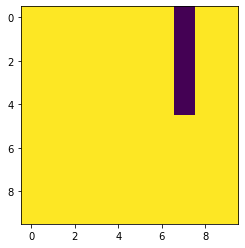

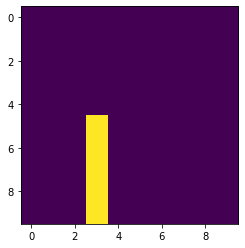

Parameter containing:
tensor([[[ 6.3567e-09,  1.5254e-13, -1.3298e-12, -8.4337e-13,  1.3325e-12,
           9.7908e-13,  2.4571e-14, -1.4139e+00,  1.7718e-13,  5.1541e-14],
         [ 6.3813e-09,  1.5127e-13, -1.3389e-12, -8.4750e-13,  1.3350e-12,
           9.8471e-13,  2.5223e-14, -1.4139e+00,  1.7666e-13,  5.2785e-14],
         [ 6.3678e-09,  1.5132e-13, -1.3327e-12, -8.4293e-13,  1.3294e-12,
           9.7700e-13,  2.4887e-14, -1.4139e+00,  1.7618e-13,  5.3775e-14],
         [ 6.4033e-09,  1.5342e-13, -1.3395e-12, -8.5138e-13,  1.3314e-12,
           9.7864e-13,  2.4274e-14, -1.4139e+00,  1.7584e-13,  5.3866e-14],
         [ 6.3850e-09,  1.4964e-13, -1.3344e-12, -8.4599e-13,  1.3341e-12,
           9.7873e-13,  2.4038e-14, -1.4139e+00,  1.7541e-13,  5.2389e-14],
         [ 1.3371e-12, -1.6948e-15, -3.6902e-15,  1.6276e-15,  4.3031e-16,
          -6.3988e-16, -5.1368e-16,  6.1495e-21, -1.8284e-15, -6.2383e-16],
         [-1.3893e-11, -6.3779e-16,  2.9354e-15, -2.0056e-15,  1.3637e-1

In [180]:
plt.imshow(Us[0].detach()); plt.show()
plt.imshow(Us[1].detach()); plt.show()
Us